# **Project Description**

In this opportunity we're going to explore the COVID-19 Radiography dataset available at https://www.kaggle.com/tawsifurrahman/covid19-radiography-database - such recopilation has been created by a team of researchers from Qatar, Bangladesh and some collaborators from Pakistan and Malaysia. Essentially it contains several chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images.

In the dataset there are 219 COVID-19 positive images, 1341 normal images and 1345 viral pneumonia images.

This notebook will go through all the steps for data preprocessing, all the issues encountered about it, a model creation and finally some testing predictions to determine how accurate our model is.

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import gc
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# Exploration of dataset's directory

In [2]:
os.listdir('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database')

['Viral Pneumonia.matadata.xlsx',
 'README.md.txt',
 'COVID-19',
 'COVID-19.metadata.xlsx',
 'NORMAL.metadata.xlsx',
 'Viral Pneumonia',
 'NORMAL']

In [3]:
#Exploring the dataset directory in more depth
#Run just in case you want to know the images are segmented in each folder

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Image exploration
In this section we're going to explore some important factors such as size, what color format they do have, do they really have the quantity expected? 

In [4]:
normal_quantity = 0
vpneumonia_quantity = 0
covid_quantity = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.png'):
            if 'NORMAL' in filename:
                normal_quantity += 1
            if 'Viral' in filename:
                vpneumonia_quantity += 1
            if 'COVID' in filename:
                covid_quantity += 1

print('Normal category quantity: ',normal_quantity)
print('Viral Pneumonia category quantity: ',vpneumonia_quantity)
print('COVID category quantity: ',covid_quantity)

Normal category quantity:  1341
Viral Pneumonia category quantity:  1345
COVID category quantity:  219


## Plotting sample images

Essentially we're going to plot random selected images to determine how they look like. Are they in grayscale? How good is their quality?

### COVID RX images

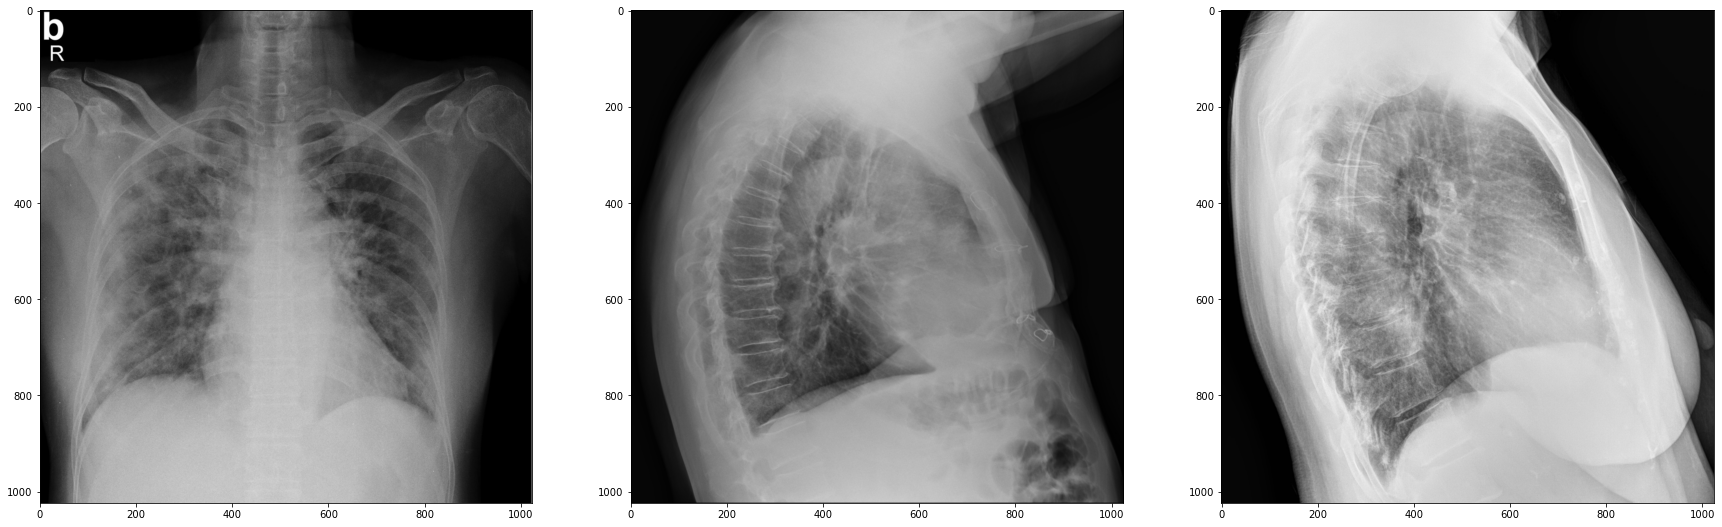

In [5]:
%matplotlib inline

plt.figure(figsize=(30,20))

ax1 = plt.subplot(131)
plt.imshow(mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19/COVID-19 (3).png'))

ax2 = plt.subplot(132)
plt.imshow(mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19/COVID-19 (27).png'))

ax3 = plt.subplot(133)
plt.imshow(mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19/COVID-19 (30).png'))

plt.show()

### Viral Pneumonia RX images

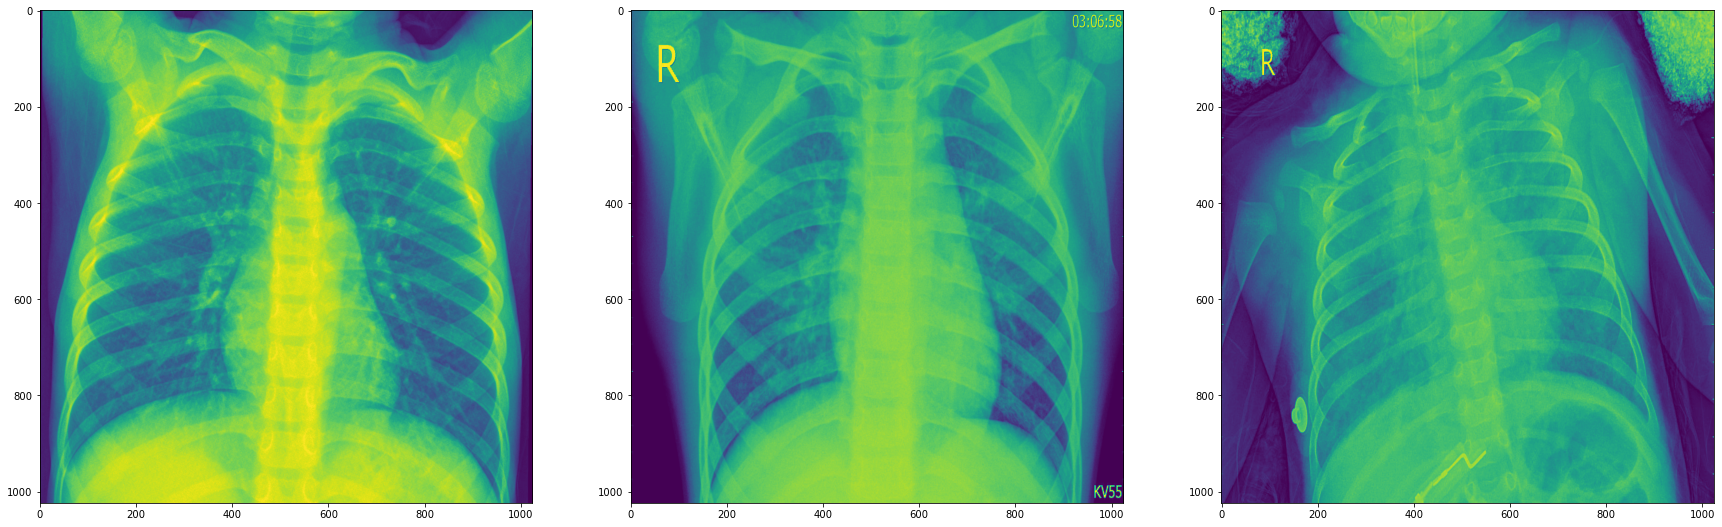

In [6]:
%matplotlib inline

plt.figure(figsize=(30,20))

ax1 = plt.subplot(131)
plt.imshow(mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (49).png'))

ax2 = plt.subplot(132)
plt.imshow(mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (82).png'))

ax3 = plt.subplot(133)
plt.imshow(mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1114).png'))

plt.show()

### Normal RX images

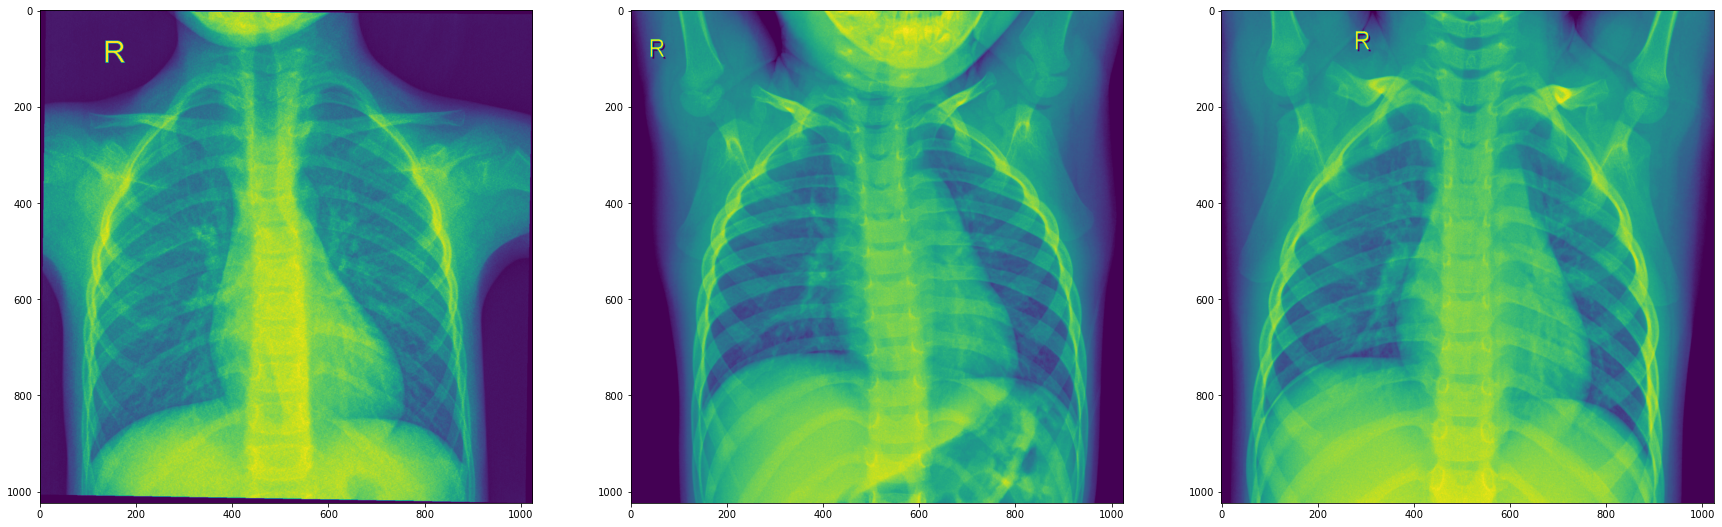

In [7]:
#Let's plot some normal images randomly to know how they look like, so we can determine important factors as color.

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(30,20))

ax1 = plt.subplot(131)
#cv2.imread('data/src/lena.jpg')
plt.imshow(mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (764).png'))

ax2 = plt.subplot(132)
plt.imshow(mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (277).png'))

ax3 = plt.subplot(133)
plt.imshow(mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (121).png'))

plt.show()

As you may see above, looks like our method (mpimg.imread()) is not taking the image array dimensions properly. To discard it's an issue with the method and not the images we're going to test with other method from the cv2 library.

In [8]:
#Let's test this hypothesis:
print('Shape of image array using cv2.imread: ',cv2.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (764).png').shape)
print('Shape of image array using mpimg.imread: ',mpimg.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (764).png').shape)

Shape of image array using cv2.imread:  (1024, 1024, 3)
Shape of image array using mpimg.imread:  (1024, 1024)


We were right. We would need to switch and use cv2.imread instead. Let's see this time.

In [9]:
normal_shape = []
vpneumonia_shape = []
covid_shape = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.png'):
            if 'NORMAL' in filename:
                normal_shape.append(cv2.imread(os.path.join(dirname, filename)).shape)
            if 'Viral' in filename:
                vpneumonia_shape.append(cv2.imread(os.path.join(dirname, filename)).shape)
            if 'COVID' in filename:
                covid_shape.append(cv2.imread(os.path.join(dirname, filename)).shape)
print('Unique shapes at Normal images set: ',set(normal_shape))
print('Unique shapes at Viral Pneumonia images set: ',set(vpneumonia_shape))
print('Unique shapes at COVID images set: ',set(covid_shape))

Unique shapes at Normal images set:  {(1024, 1024, 3)}
Unique shapes at Viral Pneumonia images set:  {(1024, 1024, 3)}
Unique shapes at COVID images set:  {(1024, 1024, 3)}


We will use cv2.imread from now on. Let's see if this method allows us to render the images properly now.

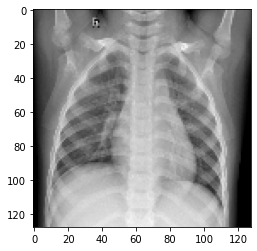

In [10]:
%matplotlib inline
plt.figure()
image = cv2.imread('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (121).png')
image = cv2.resize(image, (128, 128))
plt.imshow(image)
plt.show()      

# Data Preprocessing

During this section we'll go through taking the dataset and preparing it to then feed a CNN model. We've encountered some challenges you must be aware of before continuing the reading.

## **Data augmentation & transformation**

As you noticed before, we've got just a few images for each category which will make completely impossible to train an accurate model. In this section, we'll walk you through the process of extracting more images from the current dataset implementing data augmentation techniques. Also, we will resize the images making sure they don't miss quality. At the end of this stage, we'll transform the resulting lists to numpy arrays which will be the ones that feed the model.

In [11]:
def data_augmentation(dirname,filename):
    
    """
    This function will perform data augmentation: 
    for each one of the images, will create shifted, expanded/reduced, darker/lighter, rotated images. 9 for every modification type. 
    In total, we will create 36 extra images for every one in the original dataset.
    """
    
    image_data = []
    #reading the image
    image = cv2.imread(os.path.join(dirname, filename))
    image = cv2.resize(image, (128, 128))
    #expanding the image dimension to one sample
    samples = expand_dims(image, 0)
    # creating the image data augmentation generators
    datagen1 = ImageDataGenerator(width_shift_range=[-100,100])
    datagen2 = ImageDataGenerator(zoom_range=[0.7,1.0])
    datagen3 = ImageDataGenerator(brightness_range=[0.2,1.0])
    datagen4 = ImageDataGenerator(rotation_range=25)
      
    # preparing iterators
    it1 = datagen1.flow(samples, batch_size=1)
    it2 = datagen2.flow(samples, batch_size=1)
    it3 = datagen3.flow(samples, batch_size=1)
    it4 = datagen4.flow(samples, batch_size=1)
    image_data.append(image)
    for i in range(9):
        # generating batch of images
        batch1 = it1.next()
        batch2 = it2.next()
        batch3 = it3.next()
        batch4 = it4.next()
        # convert to unsigned integers
        image1 = batch1[0].astype('uint8')
        image2 = batch2[0].astype('uint8')
        image3 = batch3[0].astype('uint8')
        image4 = batch4[0].astype('uint8')
        #appending to the list of images
        image_data.append(image1)
        image_data.append(image2)
        image_data.append(image3)
        image_data.append(image4)
        
    return image_data

In [12]:
#Let's test our function.
result = data_augmentation('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL','NORMAL (121).png')

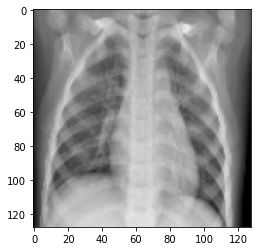

In [13]:
#Let's plot an image
%matplotlib inline
plt.figure()
image = result[6]
plt.imshow(image)
plt.show()  

In [14]:
def data_transformation(keyword):
    
    """
    This function receives a keyword as parameter to determine the kind of set it's going to process.
    It uses data_augmentation function to expand the image quantity, then resizes the images and finally returns a list containing the images already processed.
    IMPORTANT: Maybe you'll notice we don't use any Keras method which could make easier the image processing. Instead, we decided to process the images using our own functions.
    """
    
    images = []
    counter = 0
    
    if keyword == 'NORMAL':
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                if (filename.endswith('.png')) and ('NORMAL' in filename):
                    image = cv2.imread(os.path.join(dirname, filename))
                    image = cv2.resize(image, (128, 128))
                    images.append(image)
                    counter += 1
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                if (filename.endswith('.png')) and ('NORMAL' in filename):
                    result = data_augmentation(dirname,filename)
                    for i in range(len(result)):
                        if i==0:
                            continue
                        else:
                            images.append(result[i])
                            counter += 1
                if counter >= 8200:
                    break
            if counter >= 8200:
                break
                
    if keyword == 'Viral':
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                if (filename.endswith('.png')) and ('Viral' in filename):
                    image = cv2.imread(os.path.join(dirname, filename))
                    image = cv2.resize(image, (128, 128))
                    images.append(image)
                    counter += 1
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                if (filename.endswith('.png')) and ('Viral' in filename):
                    result = data_augmentation(dirname,filename)
                    for i in range(len(result)):
                        if i==0:
                            continue
                        else:
                            images.append(result[i])
                            counter += 1
                if counter >= 8200:
                    break
            if counter >= 8200:
                break
                                
    if keyword == 'COVID':
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                if (filename.endswith('.png')) and ('COVID' in filename):
                    result = data_augmentation(dirname,filename)
                    for i in range(len(result)):
                        images.append(result[i])
    return images

After several RAM limitations due to a huge dataset processing we've determined that we can take only 5000 images of each category, otherwise we'll be running out of memory. Our resulting dataset could be bigger if we reduce the images' size but we would lose quality, so we preferred to keep them 128x128 pixels and sacrify datase size.

In [15]:
normal = data_transformation('NORMAL')[:5000]
viral_pneumonia = data_transformation('Viral')[:5000]
covid = data_transformation('COVID')[:5000]

In [16]:
#Class combination
X = normal + viral_pneumonia + covid
len(X)

15000

In [17]:
#Transforming from list to numpy array.
X = np.array(X)
X.shape

(15000, 128, 128, 3)

### Label encoding:

* Normal: 0
* Viral Pneumonia: 1
* COVID-19: 2

In [18]:
class_names = ['Normal','Viral Pneumonia','COVID-19']

In [19]:
#Creating labels.
y = []
for i in range(5000):
    y.append(0)
for i in range(5000):
    y.append(1)
for i in range(5000):
    y.append(2)
y = np.array(y)
len(y)

15000

### Data splitting and shuffling
We'll split the data using the sklearn method to do so, dividing it into train and test subsets.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0,shuffle=True)

As you could read before, we've been dealing with some RAM issues as per this notebook only has 16 GBs. This is the reason why we have to free some memory along this notebook.

In [21]:
#del normal_shape
#del vpneumonia_shape
#del covid_shape
del X
#del image
del y
del normal
del viral_pneumonia
del covid
gc.collect()

18442

The line below is VERY important. In order to train the model easier and faster we need to normalize the dataset. We'll keep it the way it is due to RAM capacity issues.

In [22]:
#X_train, X_test = X_train / 255.0, X_test / 255.0

In [23]:
gc.collect()

40

# Model creation, training and evaluation

As you may know, if the goal is to achieve a very good image classifier it must be Neural Network. We're not stating you can't train a classic ML model to perform this task, obviously you can, but if you want to get high performance classifer, you should consider a Neural Network model.

In this case we will create our own Convolutional Neural Network and will keep it as simpler as possible, with some help of TensorFlow.

## CNN architecture and model explanation

A very common architecture for a CNN is a stack of Conv2D and MaxPooling layers followed by a few densily connected layers.
The core idea is that the stack of Convolutional and MaxPooling layers extract the features from the image, then these features are flattened and feed to densily connected layers that determine the class of an image based on the presence of features.

* Layer 1: Our images are 128x128 pixels of dimension; in addition, our input layer will contain 128 filters of size 3x3. In other words, we will detect 128 patterns and our response map will have dimension 126x126 (3x42 = 126) and depth of 128.

* Layer 2: The idea behind a pooling layer is to downsample our feature maps and reduce our dimensions. In this case the window will be a 2x2 frame with stride of 2 (default).

* Other layers: The next ones do very similar things but take as input the feature map from the previous layer. They increase the frequency of the filters (because previous layers shrink spacial dimensions) in order to gain more depth.

## Model creation

If you prefer to use TPU, uncomment the lines below. In this case I won't use it due to RAM capacity issues, will use GPU instead.

In [24]:
# Detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)

In [25]:
# Instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [26]:
# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
    
#    model = models.Sequential()
#    model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)))
#    model.add(layers.MaxPooling2D((2, 2)))
#    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#    model.add(layers.MaxPooling2D((2, 2)))
#    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#    model.add(layers.Flatten())
#    model.add(layers.Dense(256, activation='relu'))
#    model.add(layers.Dense(3))
    
#    model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    
#history = model.fit(X_train, y_train, epochs=6,validation_data=(X_test, y_test))

In [27]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3))

If you're curious and want to deep dive into, inspect the model summary. It's a very simple model however.

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               5

In [29]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
#Above option if you want to improve accuracy. You could also focus on improving precision or if you want to go beyond,
#educe false positive cases optimizing AUC function.
#Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

In [30]:
gc.collect()

20

## Model training

We'll implement 6 epochs only as it reaches a very good accuracy number. In the other hand, we want to keep the model to generalize well.

In [31]:
history = model.fit(X_train, y_train, epochs=6,validation_data=(X_test, y_test))

Epoch 1/6
352/352 [==============================] - 16s 45ms/step - loss: 19.5146 - accuracy: 0.6339 - val_loss: 0.7643 - val_accuracy: 0.6813
Epoch 2/6
352/352 [==============================] - 15s 43ms/step - loss: 0.8445 - accuracy: 0.6920 - val_loss: 2.2498 - val_accuracy: 0.5555
Epoch 3/6
352/352 [==============================] - 15s 44ms/step - loss: 0.6472 - accuracy: 0.7738 - val_loss: 0.3299 - val_accuracy: 0.8840
Epoch 4/6
352/352 [==============================] - 15s 44ms/step - loss: 0.9024 - accuracy: 0.8520 - val_loss: 0.3334 - val_accuracy: 0.8955
Epoch 5/6
352/352 [==============================] - 15s 43ms/step - loss: 0.2785 - accuracy: 0.9062 - val_loss: 0.7440 - val_accuracy: 0.7376
Epoch 6/6
352/352 [==============================] - 15s 43ms/step - loss: 0.2635 - accuracy: 0.9156 - val_loss: 0.2185 - val_accuracy: 0.9403


## Model evaluation

In [32]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

118/118 - 2s - loss: 0.2185 - accuracy: 0.9403
Model accuracy:  0.9402666687965393


As you could notice, the model is a very simple one but reaches very good accuracy (about 95% before final commit). We could implement more layers to make it more complex or use a pre-trained model which will deliver much better results. It's depending on the project needs and because this is a medical application, the accuracy should be much higher but like this is just a demonstration, we'll keep this model.

Let's study the predictions deeply, though.

What prediction do we get for y_pred[1] ?

In [33]:
y_pred = model.predict(X_test)

In [34]:
class_names[np.argmax(y_pred[1])]

'COVID-19'

What is the actual class?

In [35]:
class_names[y_test[1]]

'COVID-19'

## Confusion Matrix

Let's try to understand how well the predictions were achieved.

In [36]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

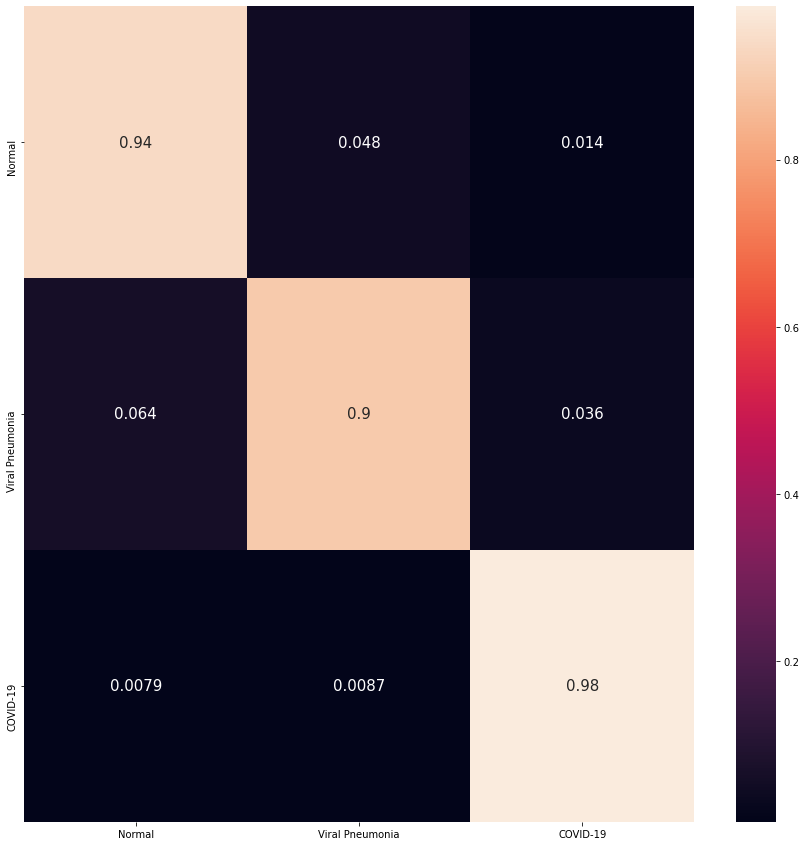

In [37]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Normal','Viral Pneumonia','COVID-19'],columns = ['Normal','Viral Pneumonia','COVID-19'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

# Conclusions

As we mentioned earlier, we wanted to walk you through all the issues we've encountered in this journey. 
We showed you how to determine some important factors about images before their pre-processing. Also showed you a few kind of blocks you can find when you're dealing with image classification.
Finally, we reached a very good accuracy implementing a very simple CNN model - If you want to achieve better results, try checking other models like MobileNetV2  and its convolutional base. 

Feel free to comment this post :)